## Practical Exercise 1: An Introduction to Word Embeddings and Word2Vec

Before we start, we would like to highlight that each of the three notebooks will contribute equally to your final grade.

This practical Exercise is presented as an IPython Notebook, with the code written for recent versions of **Python 3**.

Before working with this notebook, you need to execute some of the pre-coded cells (to load libraries/functions/modules etc.). To execute one notebook cell, press `shift-enter`. The return value of the last command will be displayed, if it is not `None`.

Below is a list with potentially useful library documentation, references, and resources:

* IPython notebooks: <https://ipython.org/ipython-doc/3/notebook/notebook.html#introduction>
* Numpy numerical array library: <https://docs.scipy.org/doc/>
* Gensim's word2vec: <https://radimrehurek.com/gensim/models/word2vec.html>
* Bokeh interactive plots: <http://bokeh.pydata.org/en/latest/> (we provide plotting code here, but click the thumbnails for more examples to copy-paste)
* scikit-learn ML library (aka `sklearn`): <http://scikit-learn.org/stable/documentation.html>
* nltk NLP toolkit: <http://www.nltk.org/>
* tutorial for processing xml in python using `lxml`: <http://lxml.de/tutorial.html> (we did this for you below, but in case you need it in the future)

#### Introduction & imports

In this notebook you will familiarize yourselves with constructing and using word-embeddings. As you recall from the lecture, word-embeddings are a type of word representation that allow words with similar meaning to have similar representations. This can be achieved by representing words as real-valued vectors in a predefined vector space. However, before delving into the embedding process, you will need to learn how to use some basic NLP tools like tokenization and regular expressions!
Good Luck and happy coding!

In [12]:
# Importing necessary libraries/modules; requires to be executed once for every session
import numpy as np
import matplotlib.pyplot as plt
import os
from random import shuffle
import re
import nltk
import pickle
from nltk.corpus import stopwords

from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook

!pip install -U gensim
from gensim.models import Word2Vec


output_notebook()
nltk.download('punkt')
nltk.download('stopwords')

!pip install wordcloud
from wordcloud import WordCloud

Loading BokehJS ...

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pomet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pomet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Here we install nltk. You only have to execute this cell once!
try:
    import nltk
except:
    import sys
    !{sys.executable} -m pip install nltk
    import nltk
    nltk.download()

### Part 0: Download the TED dataset

For this practical exercise, we need a large amount of text data. We will use the TED database, which are the transcripts of Ted Talks. The next cells will download everything you need, this might take a while as the dataset is 75MB large.

In [14]:
import zipfile
import lxml.etree

In [15]:
# Upload the dataset if it's not already there: this may take a minute..
if not os.path.isfile('ted_en-20160408.zip'):
  from google.colab import files
  # select the file "ted_en-20160408.zip" from your local drive here
  uploaded = files.upload()

In [16]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = '\n'.join(doc.xpath('//content/text()'))

print(type(input_text))

<class 'str'>


To give you a little bit of an idea about the structure of the dataset, you can open the `xml` file inside the zip folder and have a look at it. The dataset consists of metadata or properties of TedTalks, such as speaker information, language, transcripts, tags, date, and much more.

As you can see, the `xml` file has lots of different tags to mark the beginning and end of the particular datapoint. The code cell bellow shows the tags that are inside the `xml` file. As you can already imagine, the tags are used to mark different properties of the data. For this assignment, we are interested in the content/text only, which is the reason for extracting the text from the content tag and from it, create the text data.

In [17]:
# Extract all the tags in the XML
tags = [element.tag for element in doc.iter()]

# Get unique tags using a set
unique_tags = set(tags)

# Print the unique tags
for tag in unique_tags:
    print(tag)

# Delete the variable doc to save space as we have alreay extracted the necessary data we need.
del doc

translator
transcribers
transcription
talkid
wordnum
content
xml
pagesize
videopath
encoding
file
speaker
translators
seekvideo
keywords
transcriber
url
content-type
dtime
videourl
reviewer
title
reviewers
description
date
head
charnum


### Part 1: Preprocessing

Although language oftentimes follows strict rules and structures, text datasets in practice are often noisy. Before we can use our text data, we therefore need to clean it. This process is called *preprocessing*. If we don't do this, the data may be inconsistent and therefore more difficult to analyze and work with. You may ask yourself, what exactly do we need to clean, where exactly would we expect inconsistencies? Take a moment and think about it potential hickups in the raw data. What we need to do, is to preprocess the text and bring it into a clean and consistent format, allowing further analyzing steps.

<h4>Exercise 1.1 (3 Points)</h4>



The following part of the code shows a chunk of text from our ted text dataset. Have a look and try to identify **three** issues you can think of that can create a problem for text analysis, next to the one which is already provided. When giving your answer, we ask you to also mention **why** the issues could be problematic (similar to the example given). Each correct answer (naming + explaining the problem) will give 1 point.

In [18]:
# Have a look at the output of this code, to see some text examples.
i = input_text.find("Hyowon Gweon: See this?")
print(input_text[i:i+500])
print()

i = input_text.find("You will earn")
print(input_text[i:i+100])

Hyowon Gweon: See this? (Ball squeaks) Did you see that? (Ball squeaks) Cool. See this one? (Ball squeaks) Wow.
Laura Schulz: Told you. (Laughs)
(Video) HG: See this one? (Ball squeaks) Hey Clara, this one's for you. You can go ahead and play. (Laughter)
LS: I don't even have to talk, right? All right, it's nice that babies will generalize properties of blue balls to yellow balls, and it's impressive that babies can learn from imitating us, but we've known those things about babies for a very lo

You will earn 10% of any gold you distributes."
(Laughter)
So I knew I was dealing with a profession


<b>Your Solution goes here:</b>
<br>- Speakers' names: embeddings for names will dominate the embedding space unnecessarily.
<br>- Lack of Punctuation Consistency
<br>- Non-verbal sounds like ball, laughter
<br>- 

<h4>Exercise 1.2 (9 Points)</h4>

Next we want to create a preprocessing pipeline to later clean the entire dataset in one go. The pipeline takes `input_text` as input and should provide a cleaned and ready-to-use text data called `cleaned_text`.

Your task is to implement this pipeline with **three** functions that each take care of **one** of the **three** issues you listed in exercise 1.1.

Some hints about the pipeline are given as well as the code for the example from 1.1.

In [39]:
import re
import string

def remove_speaker(input_text):
    ''' Takes the text as input and removes the name of the speaker as output '''
    X = []
    for line in input_text.split('\n'):
        # Use regular expression to match lines with a speaker and remove the speaker's name
        m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
        X.extend(m.groupdict()['postcolon'])
    without_speaker = "".join(X)
    return without_speaker


def remove_noises(input_text):
    ''' Takes text as input and removes background noises (like "(laughs)") '''
    # Remove anything with parentheses in the dataset
    text = re.sub(r'\(\)', '', input_text)
    return text


def remove_punctuations(input_text):
    ''' Removes punctuation marks from the input text '''
    # Remove punctuation marks using string.punctuation set and translate method
    text = input_text.translate(str.maketrans('', '', string.punctuation))
    return text


def text_cleaned(input_text):
    ''' Takes the raw text as input, runs the text through cleaning functions,
    outputs a clean and preprocessed text for further analysis '''
    
    # Apply cleaning functions in sequence
    text_no_speaker = remove_speaker(input_text)
    text_no_noises = remove_noises(text_no_speaker)
    text_no_punctuations = remove_punctuations(text_no_noises)
    
    # Return the cleaned and preprocessed text
    text_cleaned = text_no_punctuations
    return text_cleaned

input_text_clean = text_cleaned(input_text)

<h4>Exercise 1.3 (6 Points)</h4>

To continue with building our embedding, we need to tokenize every single word (so that the model has individual tokens to process). Therefore we first need to split the text into sentences and after that into words.
Try it yourselves or use the NLTK-Tools build for this (https://www.kite.com/python/docs/nltk.word_tokenize + https://www.kite.com/python/docs/nltk.sent_tokenize).
To make it easier, we should also delete every character that is not a letter. Additionally, we could decrease the size of our vocabulary. A way to do this is by converting capital characters to lower case characters (but it also has some drawbacks - more on this in exercise 1.4).<br>

Split your text into sentences and save them in the array `sentences_strings_ted`.
Save one variabale `tokens` with all the tokens in the text and one array named `sentences_ted` that contains an array for every sentence, with all the tokenized words of that sentence.<br><br>
Example:<br>
If the text looks like this: "I love cake. You have to be honest, you love it too!", the variables should look like:<br>
sentences_strings_ted=['I love cake.', 'You have to be honest, you love it too!']<br>
sentences_ted=[['i', 'love', 'cake'], ['you', 'have', 'to', 'be', 'honest', 'you', 'love', 'it', 'too']]<br>
tokens=['i', 'love', 'cake', 'you', 'have', 'to', 'be', 'honest', 'you', 'love', 'it', 'too']<br><br>

IMPORTANT: Apply this to `input_text_clean`.<br><br>


 **[Hint:]** use pickle file (.pkl) to dump and load the variables like `sentences_strings_ted`, `tokens`, `sentences_ted` to continue where you left, when you comeback next time. It will save a lot of time/effort.

In [40]:
input_text_clean[:1000]

'Here are two reasons companies fail they only do more of the same or they only do whats newTo me the real real solution to quality growth is figuring out the balance between two activities exploration and exploitation Both are necessary but it can be too much of a good thingConsider Facit Im actually old enough to remember them Facit was a fantastic company They were born deep in the Swedish forest and they made the best mechanical calculators in the world Everybody used them And what did Facit do when the electronic calculator came along They continued doing exactly the same In six months they went from maximum revenue  and they were gone GoneTo me the irony about the Facit story is hearing about the Facit engineers who had bought cheap small electronic calculators in Japan that they used to doublecheck their calculatorsLaughterFacit did too much exploitation But exploration can go wild tooA few years back I worked closely alongside a European biotech company Lets call them OncoSearc

In [11]:
# Tokenize sentences using NLTK
sentences_strings_ted  = nltk.tokenize.sent_tokenize(input_text_clean)
print(sentences_strings_ted)
# Word Tokenization and Preprocessing
tokens = []  # List to store all tokens in the text
sentences_ted = []  # List to store tokenized words for each sentence

# Loop through each sentence
for sentence in sentences_strings_ted:
    # Word Tokenization
    words = nltk.tokenize.word_tokenize(sentence)

    # Remove Non-Letter Characters and Lowercasing
    words = [word.lower() for word in words if word.isalpha()]

    # Extend the tokens list with the words in the current sentence
    tokens.extend(words)
    
    # Append the list of tokenized words for the current sentence
    sentences_ted.append(words)

KeyboardInterrupt: 

In [69]:
# Save the variables using pickle
with open('preprocessed_data.pkl', 'wb') as file:
    pickle.dump((sentences_strings_ted, tokens, sentences_ted), file)

In [20]:
# Load data from the file
with open('preprocessed_data.pkl', 'rb') as file:
    sentences_strings_ted, tokens, sentences_ted = pickle.load(file)

<h4>Exercise 1.4 (1 Point)</h4>

The good side of converting all capital letters is, that we reduce the volume of the vocabulary. Thereby we dont differentiate between the the words "today" and "Today". But there is a caveat. Can you think of any downside to this process?

**Your answer goes here:**
1. Becomes for difficult to distinguish personal names from not personal names
2. Makes sentiment analysis more difficult (some words are emphisised with capital letters)


Let's quickly see how large our vocabulary turned out to be!

In [21]:
len(sentences_ted)

273649

### Part 2: Word Frequencies

<h4>Exercise 2.1 (2 Points)</h4>

Your next task will be to store the counts of the top 1,000 most frequent words in a list called `counts_ted_top1000` ! There are multiple ways to do this. You can have a look at the Counter-Function (https://docs.python.org/2/library/collections.html) or the FreqDist-Function (https://www.kite.com/python/docs/nltk.FreqDist). If you don't trust any of these, you can of course build your own function. In the end we want an array with tuples of the structure:

counts_ted_top1000 =  [(WordA,FrequencyA),(WordB,FrequencyB)]

In [22]:
# Calculate word frequencies using NLTK FreqDist
word_frequencies = nltk.FreqDist(tokens)

# Get the 1000 most common words and their counts
counts_ted_top1000 = word_frequencies.most_common(1000)

In [23]:
# Print the top 1000 most frequent words
print("The 1000 most frequent words are:")
for word, frequency in counts_ted_top1000:
    print(f"{word}, {frequency}")

The 1000 most frequent words are:
the, 207745
and, 149171
to, 124886
of, 114750
a, 105005
that, 95167
i, 83056
in, 77904
it, 74734
you, 70956
we, 67657
is, 64390
this, 49273
so, 36932
they, 33105
was, 31902
for, 29675
are, 28494
have, 27846
but, 26748
what, 26519
do, 26073
on, 25831
with, 24719
can, 21488
about, 21249
there, 21049
be, 20190
as, 19483
not, 19308
at, 19226
all, 18890
my, 17930
one, 17165
people, 16724
like, 16046
if, 15866
from, 15458
now, 14392
our, 14065
he, 13995
an, 13917
just, 13897
these, 13881
or, 13841
when, 13280
because, 12881
very, 12368
me, 12296
out, 12048
by, 11867
them, 11593
how, 11565
know, 11488
going, 11364
up, 11130
had, 11091
more, 10907
would, 10579
were, 10533
think, 10463
who, 10447
see, 10175
your, 10094
their, 10031
which, 10024
here, 9895
really, 9675
get, 9378
then, 9224
us, 8836
world, 8811
some, 8620
time, 8567
has, 8449
laughter, 8422
could, 8105
actually, 8014
into, 7862
where, 7722
way, 7691
did, 7668
will, 7618
things, 7538
years, 7519
o

The following code is going to plot a histogram with the counts of the  top-30 words as bars.

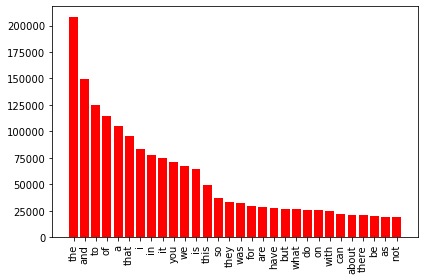

In [24]:
mostfreqn=30 # Here we define how many of them we want to see in the diagramm
frequency=[y for (x,y) in counts_ted_top1000][:mostfreqn]
word=[x for (x,y) in counts_ted_top1000][:mostfreqn]
indices = np.arange(len(counts_ted_top1000[:mostfreqn]))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

Exercise: You can clearly see, that many of the most common words are redundant and not very meaningful. These types of words are called **stopwords**. What problems can stop words create in the NLP and why it is important to remove them?

**Your answer goes here:**
1. They do not carry much of a meaning
2. Can increase the dimensionality of the data

<h4>Exercise 2.2 (2 Points)</h4>

Now, write a function that removes the stopwords from the variable `counts_ted_top1000` and save it as `counts_ted_top1000_no_stopword`. Use the code for visualization and spot the differences.

The structure in the end should look like this: counts_ted_top1000_no_stopword = [(WordA,FrequencyA),(WordB,FrequencyB)]

In [25]:
from nltk.corpus import stopwords

In [26]:
# Create a set of English stopwords
stop_words = set(stopwords.words('english'))

# Filter out stopwords from the list of tokens
filtered_sentence = [w for w in tokens if not w.lower() in stop_words]

# Create a frequency distribution of the filtered tokens
word_frequencies = nltk.FreqDist(filtered_sentence)

# Get the 1000 most common words after removing stopwords
counts_ted_top1000_no_stopword = word_frequencies.most_common(1000)

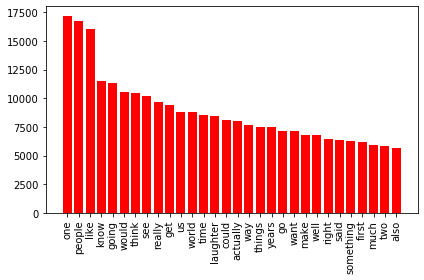

In [27]:
mostfreqn=30 # Here we define how many of them we want to see in the diagramm
frequency=[y for (x,y) in counts_ted_top1000_no_stopword][:mostfreqn]
word=[x for (x,y) in counts_ted_top1000_no_stopword][:mostfreqn]
indices = np.arange(len(counts_ted_top1000_no_stopword[:mostfreqn]))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

#### Wordcloud Visualization

The below so-called **wordcloud** shows the most frequent words in a larger font and the less frequent ones in a smaller font size. It's a quick and cool way of visualizing the most frequent words!

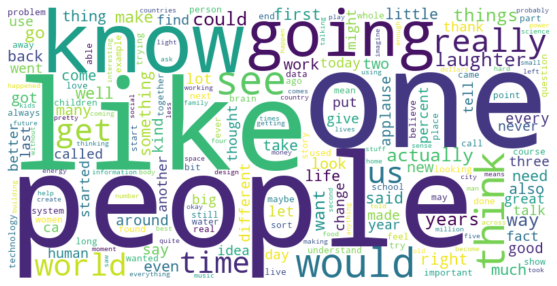

In [28]:
# Create a dictionary that maps words to their frequencies
counts_ted_top1000_no_stopword = {word: count for word, count in counts_ted_top1000_no_stopword}

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud
wordcloud.generate_from_frequencies(counts_ted_top1000_no_stopword)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Part 3: Generating the Word Embeddings with Word2Vec

Now it is time to run the embedding model. Gensim has an already implemented model that you can use. Using the provided model is enough for the purposes of our notebook. If you want to dive deeper into the topic - this youtube video https://www.youtube.com/watch?v=kKDYtZfriI8 could be a great guidance for you to get started.

In [29]:
model_ted = Word2Vec(sentences_ted)

### Part 4: Inspection of our learned representations/embeddings (3 Points)


Now that we have a model that captures the word embeddings, we can use it to explore properties of the words in the text.

First, code a line that looks at the embedding of one individual word/token.  What does the representation of "house" look like in the embedding model? You may refer to the following gensim docs for functions, that might help you https://radimrehurek.com/gensim/models/keyedvectors.html). This will give you 1 point.

In [30]:
from gensim.models import KeyedVectors
# Extracting the word vector for the word "house" from the trained Word2Vec model
word_vector = model_ted.wv["house"]

# Printing the vector representation of the word
print(f"Vector for 'house': {word_vector}")

Vector for 'house': [-0.46434417 -0.29509994  0.42627537 -1.0309836   1.26637    -0.395657
 -0.8882464  -2.2583926  -0.7258356   0.7165687   0.2666645  -0.05269838
 -0.68417335  1.4012575   1.2564899   0.69246566 -0.33647928  0.34063822
  1.1245798  -0.41095227  0.3072063  -0.36453193  0.6521911  -0.10972846
  0.72026837  0.20348586  0.5730618   0.49809098 -1.9197153  -1.0554398
  1.6923529  -0.28961116 -2.0501075   0.505125   -1.2638857   0.38717797
 -1.311967    0.07575388 -1.919429    0.9119634   1.4423063   1.2865795
 -1.2378172   0.6337643  -0.73466843  0.6995707   0.9889787  -1.6260515
  1.4181049   0.26745784 -0.0746371  -2.0845165  -0.62299204 -0.66533464
  0.09443172  0.14958377  0.46457317  1.0182687   0.59578896  0.6253717
  0.54095227  1.2779647  -0.5785377  -0.3101451   1.5591544   0.7326784
 -0.30944815 -1.3493277  -0.1644367   0.8512089  -0.25284073  0.30107826
  0.08515931  0.07380744 -0.70092463  0.93429387 -0.96518713 -1.4058365
  0.58646    -0.2984331   0.849272    0

The next task for you is to output the most similar word to "town"? This will also give you 1 point.

In [31]:
# Find the most similar word to "town" using the Word2Vec model
similar_words = model_ted.wv.similar_by_word("town")

# Print the most similar word
print(f"Most similar word: {similar_words[0]}")

Most similar word: ('village', 0.8671132326126099)


Finally, we want to find out how similar the words "town" and "house" are. Again: 1 point for this!

In [32]:
# Calculate the similarity between "town" and "house" using the Word2Vec model
similarity = model_ted.wv.similarity("town", "house")

# Print the similarity score
print(f"Similarity between 'town' and 'house': {similarity}")

Similarity between 'town' and 'house': 0.7464375495910645


<h4>Exercise 4.1 (3 Points)</h4>


Now that we have generated our embeddings, let's test some classical ideas:
implement the following formula. Print out the 10 words, that are most similar to this formula: <br>
$King-Man+Woman=???$
There are two ways of computing similarity in word embeddings:
 - https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html
 - https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar_cosmul.html
You should try out both! In this case one of them is better, but both of them are valid methods for computing similarity in the word-space.

In [33]:
# Find words that are similar to "woman" and "king" but dissimilar to "man" using Word2Vec model
similar_words = model_ted.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)

print(f"Most similar words to 'woman' and 'king' (excluding 'man'): {similar_words}")


Most similar words to 'woman' and 'king' (excluding 'man'): [('president', 0.7955580353736877), ('german', 0.7510263919830322), ('obama', 0.7397924661636353), ('luther', 0.7392354011535645), ('queen', 0.7391101717948914), ('minister', 0.7391051650047302), ('nelson', 0.7319698333740234), ('french', 0.7273588180541992), ('james', 0.725019633769989), ('royal', 0.7210901975631714)]


Exercise 4.2 (2 Points)

The expected outcome (Queen) should be one of the top ten most similar words. But there are also a lot of words, that you would not expect. Think about where how these words might be connected to the formula. Take your time and understand why some of the words (luther, mary, dr, president) might be in this list.

There can be some biases in the text????

#### t-SNE visualization

We will use the t-SNE algorithm, given below, for visualization. The so-called t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised and non-linear machine learning technique. It is commonly used for visualizing high dimensional data (just like our high dimensional vectors). You do not have to understand the code, its purpose is simply to give you an idea of how the data is arranged in high dimensional space.

<h4>Exercise 4.3 (2 Points)</h4>

To use the t-SNE code below, first put a list of the top 50 words (as **strings**, without **stopwords**) into a variable `words_top_ted`.

In [34]:
# Select the top 50 words from the list of counts (counts_ted_top1000_no_stopword)
words_top_ted = list(counts_ted_top1000_no_stopword.keys())[:50]

The following code gets the corresponding vectors from the model, assuming it's called `model_ted`:

In [35]:
# This assumes words_top_ted is a list of strings, the top 250 words
words_top_vec_ted = model_ted.wv[words_top_ted]

The next few lines are for the t-SNE visualization.

In [36]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(words_top_vec_ted)

In [37]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words_top_ted))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

That's it. We hope you had fun and learned something in the process :-)